In [1]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = 'UCI_HAR_Dataset/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = 'UCI_HAR_Dataset/'+subset+'/y_'+subset+'.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [10]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

/home/j_choudhary1001/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [11]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [13]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [14]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [15]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [16]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [17]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

/home/j_choudhary1001/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [20]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


# 1 layer architecture

In [32]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [34]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 46s 6ms/step - loss: 1.3306 - acc: 0.4361 - val_loss: 1.1743 - val_acc: 0.4723
Epoch 2/30
7352/7352 [==============================] - 43s 6ms/step - loss: 0.9716 - acc: 0.5788 - val_loss: 0.9656 - val_acc: 0.5263
Epoch 3/30
7352/7352 [==============================] - 43s 6ms/step - loss: 0.7787 - acc: 0.6510 - val_loss: 0.7841 - val_acc: 0.6135
Epoch 4/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.6911 - acc: 0.6587 - val_loss: 0.7109 - val_acc: 0.6203
Epoch 5/30
7352/7352 [==============================] - 46s 6ms/step - loss: 0.6496 - acc: 0.6794 - val_loss: 0.8000 - val_acc: 0.6362
Epoch 6/30
7352/7352 [==============================] - 47s 6ms/step - loss: 0.8295 - acc: 0.6221 - val_loss: 0.7970 - val_acc: 0.6318
Epoch 7/30
7352/7352 [==============================] - 46s 6ms/step - loss: 0.5920 - acc: 0.7

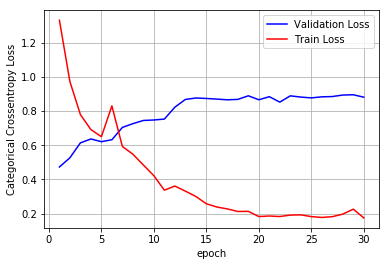

In [41]:
epochs = 30
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = val_loss #history.history['val_loss']
ty = train_loss #history.history['loss']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

In [35]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      398        66        0                   0   
STANDING                 0      100       418        2                   0   
WALKING                  0        3         0      465                   8   
WALKING_DOWNSTAIRS       0        0         0        0                 360   
WALKING_UPSTAIRS         0        3         0       23                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                           27  
STANDING                          12  
WALKING                           20  
WALKING_DOWNSTAIRS                60  
WALKING_UPSTAIRS                 444  


In [36]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 526us/step


In [37]:
score

[0.4692274864947224, 0.8805564981336953]

# With 64 hidden units and 1 layer, dropout = 0.5

In [38]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 64

In [39]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [41]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 53s 7ms/step - loss: 1.2776 - acc: 0.4241 - val_loss: 1.2997 - val_acc: 0.4432
Epoch 2/30
7352/7352 [==============================] - 53s 7ms/step - loss: 1.0893 - acc: 0.5087 - val_loss: 1.3274 - val_acc: 0.4669
Epoch 3/30
7352/7352 [==============================] - 53s 7ms/step - loss: 0.8866 - acc: 0.6197 - val_loss: 0.7990 - val_acc: 0.6535
Epoch 4/30
7352/7352 [==============================] - 54s 7ms/step - loss: 0.7111 - acc: 0.6983 - val_loss: 0.7417 - val_acc: 0.6810
Epoch 5/30
7352/7352 [==============================] - 53s 7ms/step - loss: 0.5629 - acc: 0.7665 - val_loss: 0.6835 - val_acc: 0.7255
Epoch 6/30
7352/7352 [==============================] - 54s 7ms/step - loss: 0.5324 - acc: 0.8006 - val_loss: 0.6378 - val_acc: 0.7944
Epoch 7/30
7352/7352 [==============================] - 55s 8ms/step - loss: 0.3949 - acc: 0.8708 - val_loss: 0.5324 - val_acc: 0.8303
Epoch 8

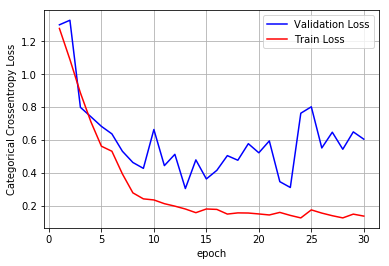

In [43]:
epochs = 30
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = val_loss #history.history['val_loss']
ty = train_loss #history.history['loss']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

In [42]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      371       101        0                   1   
STANDING                 0       55       477        0                   0   
WALKING                  0        0         0      453                  30   
WALKING_DOWNSTAIRS       0        0         0        1                 418   
WALKING_UPSTAIRS         0        0         0        0                   7   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                           18  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 464  


In [43]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 765us/step


In [44]:
score

[0.6057351109406184, 0.9138106549032915]

# LSTM layer with droput rate = 0.3

In [51]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 64

In [52]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.3))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [54]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 49s 7ms/step - loss: 1.2948 - acc: 0.4331 - val_loss: 1.0448 - val_acc: 0.5436
Epoch 2/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.8782 - acc: 0.6260 - val_loss: 0.8597 - val_acc: 0.6675
Epoch 3/30
7352/7352 [==============================] - 50s 7ms/step - loss: 0.6893 - acc: 0.7145 - val_loss: 0.5970 - val_acc: 0.7516
Epoch 4/30
7352/7352 [==============================] - 50s 7ms/step - loss: 0.5735 - acc: 0.7767 - val_loss: 0.6821 - val_acc: 0.7686
Epoch 5/30
7352/7352 [==============================] - 50s 7ms/step - loss: 0.4630 - acc: 0.8445 - val_loss: 0.6195 - val_acc: 0.7635
Epoch 6/30
7352/7352 [==============================] - 51s 7ms/step - loss: 0.3291 - acc: 0.8924 - val_loss: 0.5421 - val_acc: 0.8341
Epoch 7/30
7352/7352 [==============================] - 51s 7ms/step - loss: 0.2729 - acc: 0.9129 - val_loss: 0.5773 - val_acc: 0.8381
Epoch 8

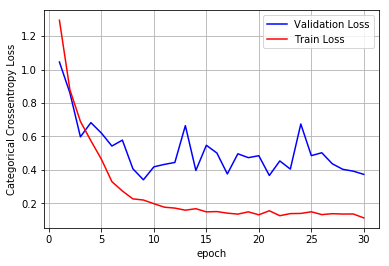

In [45]:
epochs = 30
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = val_loss #history.history['val_loss']
ty = train_loss #history.history['loss']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

In [55]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 536        0         0        0                   0   
SITTING                  8      435        48        0                   0   
STANDING                 0      149       383        0                   0   
WALKING                  0        0         0      459                  24   
WALKING_DOWNSTAIRS       0        0         0        0                 417   
WALKING_UPSTAIRS         0        1         0       14                   9   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            0  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                 3  
WALKING_UPSTAIRS                 447  


In [56]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 928us/step


In [57]:
score

[0.3724719570703537, 0.9083814048184594]

# 2 LSTM layers with 32 units and dropouts (rate = 0.3)

In [58]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [66]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.3))
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.3))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128, 32)           5376      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 32)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 30,598
Trainable params: 30,598
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [68]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 95s 13ms/step - loss: 1.0129 - acc: 0.5539 - val_loss: 0.8788 - val_acc: 0.6332
Epoch 2/30
7352/7352 [==============================] - 92s 12ms/step - loss: 0.6742 - acc: 0.6718 - val_loss: 0.9047 - val_acc: 0.6688
Epoch 3/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5041 - acc: 0.8041 - val_loss: 0.7184 - val_acc: 0.7906
Epoch 4/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.3471 - acc: 0.8819 - val_loss: 0.5927 - val_acc: 0.8388
Epoch 5/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.2545 - acc: 0.9115 - val_loss: 0.4560 - val_acc: 0.8626
Epoch 6/30
7352/7352 [==============================] - 96s 13ms/step - loss: 0.2148 - acc: 0.9206 - val_loss: 0.4704 - val_acc: 0.8778
Epoch 7/30
7352/7352 [==============================] - 98s 13ms/step - loss: 0.1837 - acc: 0.9276 - val_loss: 0.5517 - val_acc: 0.8612


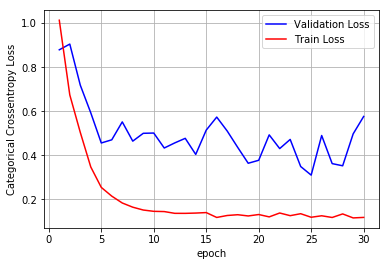

In [48]:
epochs = 30
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = val_loss #history.history['val_loss']
ty = train_loss #history.history['loss']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

In [69]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 509        1         0        0                   0   
SITTING                  2      415        68        1                   4   
STANDING                 0      113       419        0                   0   
WALKING                  0        0         0      445                  48   
WALKING_DOWNSTAIRS       0        0         0        0                 418   
WALKING_UPSTAIRS         0        2         0        3                  22   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                            1  
STANDING                           0  
WALKING                            3  
WALKING_DOWNSTAIRS                 2  
WALKING_UPSTAIRS                 444  


In [70]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 1ms/step


In [71]:
score

[0.5762635302961742, 0.8992195453003053]

# 32 hidden units with 1 layer and dropout = 0.8 and optimizer = Adam

In [18]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [21]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.8))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 32s 4ms/step - loss: 1.4956 - acc: 0.3532 - val_loss: 1.4063 - val_acc: 0.3750
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.3513 - acc: 0.4098 - val_loss: 1.2775 - val_acc: 0.4632
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.2975 - acc: 0.4422 - val_loss: 1.2481 - val_acc: 0.4801
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.1789 - acc: 0.5196 - val_loss: 1.0614 - val_acc: 0.5914
Epoch 5/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.9993 - acc: 0.5729 - val_loss: 0.8984 - val_acc: 0.5891
Epoch 6/30
7352/7352 [==============================] - 31s 4ms/step - loss: 1.0076 - acc: 0.5379 - val_loss: 1.0226 - val_acc: 0.5416
Epoch 7/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.9790 - acc: 0.5

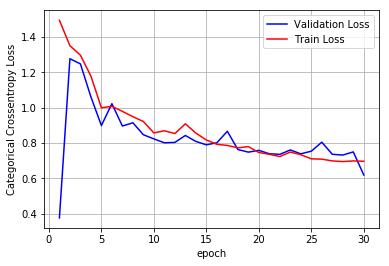

In [50]:
epochs = 30
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = val_loss #history.history['val_loss']
ty = train_loss #history.history['loss']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

In [24]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING
True                                                  
LAYING                 510        0        27        0
SITTING                  0      394        95        2
STANDING                 0      106       422        4
WALKING                  0        0         0      496
WALKING_DOWNSTAIRS       0        0         1      419
WALKING_UPSTAIRS         0        1         2      468


In [25]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 415us/step


In [26]:
score

[0.7457214260519986, 0.6182558534102477]

# 2 layer with 32 units and dropout = 0.5

In [28]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [32]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, return_sequences = True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Configuring the parameters
model.add(LSTM(64))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 30,598
Trainable params: 30,598
Non-trainable params: 0
_________________________________________________________________


In [33]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [34]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 76s 10ms/step - loss: 1.0496 - acc: 0.5273 - val_loss: 0.8828 - val_acc: 0.5887
Epoch 2/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.7390 - acc: 0.6517 - val_loss: 0.7472 - val_acc: 0.6892
Epoch 3/30
7352/7352 [==============================] - 74s 10ms/step - loss: 0.6433 - acc: 0.7055 - val_loss: 0.6822 - val_acc: 0.7068
Epoch 4/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.5050 - acc: 0.7746 - val_loss: 0.7357 - val_acc: 0.7122
Epoch 5/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.4415 - acc: 0.8039 - val_loss: 0.5275 - val_acc: 0.7974
Epoch 6/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.3536 - acc: 0.8701 - val_loss: 0.5187 - val_acc: 0.8303
Epoch 7/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.2637 - acc: 0.9079 - val_loss: 0.4236 - val_acc: 0.8707


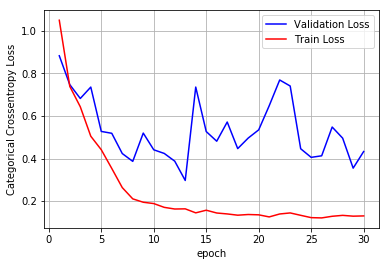

In [52]:
epochs = 30
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = val_loss #history.history['val_loss']
ty = train_loss #history.history['loss']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

In [42]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      371       101        0                   1   
STANDING                 0       55       477        0                   0   
WALKING                  0        0         0      453                  30   
WALKING_DOWNSTAIRS       0        0         0        1                 418   
WALKING_UPSTAIRS         0        0         0        0                   7   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                           18  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 464  


In [43]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 765us/step


In [44]:
score

[0.6057351109406184, 0.9138106549032915]

In [54]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Layers", "Hidden Units", "Dropout", "Loss", "Accuracy"]

x.add_row(["1 layer", 32, 0.5, 0.45, 0.88])
x.add_row(["1 layer", 64, 0.5, 0.60, 0.9138])
x.add_row(["1 layer", 64, 0.3, 0.37, 0.9083])
x.add_row(["2 layer", 32, 0.3, 0.57, 0.8992])
x.add_row(["1 layer, optimizer = adam", 32, 0.8, 0.74, 0.6182])
x.add_row(["2 layer", 32, 0.5, 0.60, 0.9138])
print(x)

+---------------------------+--------------+---------+------+----------+
|           Layers          | Hidden Units | Dropout | Loss | Accuracy |
+---------------------------+--------------+---------+------+----------+
|          1 layer          |      32      |   0.5   | 0.45 |   0.88   |
|          1 layer          |      64      |   0.5   | 0.6  |  0.9138  |
|          1 layer          |      64      |   0.3   | 0.37 |  0.9083  |
|          2 layer          |      32      |   0.3   | 0.57 |  0.8992  |
| 1 layer, optimizer = adam |      32      |   0.8   | 0.74 |  0.6182  |
|          2 layer          |      32      |   0.5   | 0.6  |  0.9138  |
+---------------------------+--------------+---------+------+----------+


# Steps followed

1. Loaded the train and test datasets
2. Defined the architecture of LSTM
3. Trained the network with different configurations